 # data-augmentation

In [23]:
# efficientnetのロード
# !pip install --quiet efficientnet

In [24]:
# ライブラリーのロード
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from kaggle_datasets import KaggleDatasets
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate, Normalize
)
import albumentations

## TPU or GPUの設定

In [25]:
# TPU or GPU setting
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

REPLICAS: 1


In [114]:
N_CLASSES = 5
IMAGE_SIZE = [512, 512]
BATCH_SIZE = 16
AUG_BATCH = 16
CUTMIX_MIXUP_ARG_P = 0

## データのロードセクション

In [27]:
# データのパスを指定する(tfrecordにすること)
GCS_PATH = KaggleDatasets().get_gcs_path('cassava-leaf-disease-tfrecords-512x512')
FILENAME_COMP = tf.io.gfile.glob(GCS_PATH + '/*.tfrec')

In [28]:
# 数える関数
def count_data_items(filename):
    n = [int(re.compile(r'-([0-9]*)\.').search(filename).group(1)) for name in filenames]
    return np.sum(n)

In [29]:
# affine変換用の行列
# original(https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96)
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

In [30]:
# affine transform
# original(https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96)
# 各種パラメータはalbumentationに合わせたはず...
def affine_transform(image):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    # rot = 15. * tf.random.normal([1],dtype='float32')
    rot = 45. * tf.random.uniform([1], -1.0, 1.0, dtype='float32')
    # shr = 5. * tf.random.normal([1],dtype='float32') 
    shr = 0. * tf.random.normal([1],dtype='float32') 
    # h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    # w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    # h_shift = 16. * tf.random.normal([1],dtype='float32') 
    h_shift = 0.0625 * tf.random.uniform([1], -1.0, 1.0, dtype='float32') 
    # w_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 0.0625 * tf.random.uniform([1], -1.0, 1.0, dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

In [31]:
def data_augment(image, label, transpose_arg_p = 0, random_crop_arg_p = 0, 
                 horizontal_flip_arg_p = 0.5, vertical_flip_arg_p = 0.5, 
                 affine_transform_arg_p = 0.5
                ):
    p_random_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_transpose = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_vertical_flip = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_horizontal_flip = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_affine_transform= tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_random_crop <= random_crop_arg_p:
        image = tf.image.random_crop(image, size=[IMAGE_SIZE[0], IMAGE_SIZE[1], 3])
    
    # transpose
    if p_transpose <= transpose_arg_p:
        image = tf.transpose(image, perm=[1, 0, 2])
    
    # vertical_flip
    if p_vertical_flip <= vertical_flip_arg_p:
        image = tf.image.flip_left_right(image)
    
    # horizontal_flip
    if p_vertical_flip <= vertical_flip_arg_p:
        image = tf.image.flip_up_down(image)
    
    # affine_transform
    if p_affine_transform <= affine_transform_arg_p:
        image = affine_transform(image)
    

    
    return image, label

## albumentationのaugmentation

In [32]:
# albumentationのaugmentation
alb_transforms = Compose([
    # albumentations.Cutout(max_h_size=int(IMAGE_SIZE[0] * 0.3), max_w_size=int(IMAGE_SIZE[1] * 0.3), num_holes=1, p=0.5), 
    # RandomBrightness(p=),
    Normalize(), 
])
def aug_fn(image):
    data ={"image":image}
    aug_data = alb_transforms(**data)
    aug_img = aug_data["image"]
    # aug_img = tf.cast(aug_img/255.0, tf.float32)
    return aug_img

def alb_process_data(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
    return aug_img, label

## cutmix-mixupのaugmentation

In [33]:
def cutmix(image, label, PROBABILITY = 1.0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with cutmix applied
    DIM = IMAGE_SIZE[0]
    CLASSES = N_CLASSES
    
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        # DO CUTMIX WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)
        # CHOOSE RANDOM IMAGE TO CUTMIX WITH
        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
        WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # MAKE CUTMIX IMAGE
        one = image[j,ya:yb,0:xa,:]
        two = image[k,ya:yb,xa:xb,:]
        three = image[j,ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)
        # MAKE CUTMIX LABEL
        a = tf.cast(WIDTH*WIDTH/DIM/DIM,tf.float32)
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j], N_CLASSES)
            lab2 = tf.one_hot(label[k], N_CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image2,label2

In [34]:
def mixup(image, label, PROBABILITY = 1.0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with mixup applied
    DIM = IMAGE_SIZE[0]
    CLASSES = N_CLASSES
    
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        # DO MIXUP WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.float32)
        # CHOOSE RANDOM
        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        a = tf.random.uniform([],0,1)*P # this is beta dist with alpha=1.0
        # MAKE MIXUP IMAGE
        img1 = image[j,]
        img2 = image[k,]
        imgs.append((1-a)*img1 + a*img2)
        # MAKE CUTMIX LABEL
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j], N_CLASSES)
            lab2 = tf.one_hot(label[k], N_CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image2,label2

In [95]:
# cutmixとmixupを合わせる。
def cutmix_mixup_transform(image,label, cutmix_mixup_arg_p = CUTMIX_MIXUP_ARG_P):
    p_cutmix_mixup = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if cutmix_mixup_arg_p <  p_cutmix_mixup:
        return image, label
    
    # THIS FUNCTION APPLIES BOTH CUTMIX AND MIXUP
    DIM = IMAGE_SIZE[0]
    CLASSES = N_CLASSES
    # TODO: パラメータを管理すること
    SWITCH = 0.5 
    CUTMIX_PROB = 0.5
    MIXUP_PROB = 0.5
    # FOR SWITCH PERCENT OF TIME WE DO CUTMIX AND (1-SWITCH) WE DO MIXUP
    image2, label2 = cutmix(image, label, CUTMIX_PROB)
    image3, label3 = mixup(image, label, MIXUP_PROB)
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        P = tf.cast( tf.random.uniform([],0,1)<=SWITCH, tf.float32)
        imgs.append(P*image2[j,]+(1-P)*image3[j,])
        labs.append(P*label2[j,]+(1-P)*label3[j,])
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image4 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label4 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image4,label4

In [115]:
def decode_image(image_data):
    """
        Decode a JPEG-encoded image to a uint8 tensor.
    """
    image = tf.image.decode_jpeg(image_data, channels=3)
    return image

# フロートに変換することだけに注意
def scale_image(image, label):
    """
        Cast tensor to float and normalizes (range between 0 and 1).
    """
    image = tf.cast(image, tf.float32)
    image /= 255.0
    return image, label

def image_to_float(image, label):
    image = tf.cast(image, tf.float32)
    return image, label


def read_tfrecord(example, labeled=True):
    """
        1. Parse data based on the 'TFREC_FORMAT' map.
        2. Decode image.
        3. If 'labeled' returns (image, label) if not (image, name).
    """
    if labeled:
        TFREC_FORMAT = {
            'image': tf.io.FixedLenFeature([], tf.string), 
            'target': tf.io.FixedLenFeature([], tf.int64), 
        }
    else:
        TFREC_FORMAT = {
            'image': tf.io.FixedLenFeature([], tf.string), 
            'image_name': tf.io.FixedLenFeature([], tf.string), 
        }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    if labeled:
        label_or_name = tf.cast(example['target'], tf.int32)
        # One-Hot Encoding needed to use "categorical_crossentropy" loss
        label_or_name = tf.one_hot(tf.cast(label_or_name, tf.int32), N_CLASSES)
    else:
        label_or_name = example['image_name']
    return image, label_or_name


def get_dataset(FILENAMES, labeled=True, ordered=False, cached=False, augment=False):
    
    ignore_order = tf.data.Options()
    
    if not ordered:
        ignore_order.experimental_deterministic = False
        dataset = tf.data.Dataset.list_files(FILENAMES)
        dataset = dataset.interleave(tf.data.TFRecordDataset, num_parallel_calls=AUTO)
    else:
        dataset = tf.data.TFRecordDataset(FILENAMES, num_parallel_reads=AUTO)
    
    
    dataset = dataset.with_options(ignore_order)
    # データの読み込み
    dataset = dataset.map(lambda x: read_tfrecord(x, labeled=labeled), num_parallel_calls=AUTO)
    
    # data augmentation
    if augment:
        # バッチ化する必要のあるaugmentation
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
        
        dataset = dataset.map(image_to_float, num_parallel_calls=AUTO)
        if CUTMIX_MIXUP_ARG_P > 0:
            dataset = dataset.batch(AUG_BATCH)
            dataset = dataset.map(cutmix_mixup_transform, num_parallel_calls=AUTO)
            dataset = dataset.unbatch()
        
        # albumentationの処理
        dataset = dataset.map(alb_process_data, num_parallel_calls=AUTO)
    else:
        # この場合は、255で割ることに注意
        dataset = dataset.map(scale_image, num_parallel_calls=AUTO)  
    dataset = dataset.batch(BATCH_SIZE) 
    return dataset

## データセット表示用

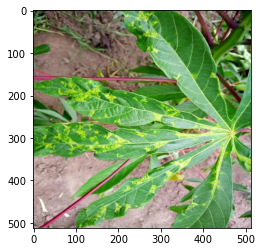

In [37]:
train_dataset = get_dataset(FILENAME_COMP, ordered=True)
dataset = train_dataset.unbatch()
for img, label in dataset:
    plt.imshow(img.numpy())
    break

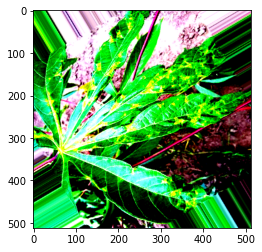

In [116]:
train_dataset = get_dataset(FILENAME_COMP, ordered=True, augment=True)
dataset = train_dataset.unbatch()
for img, label in dataset:
    plt.imshow(img.numpy())
    break

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 0., 1., 0.], dtype=float32)>